MNIST classifier exercise from Hands on Machine Learning in Tensorflow and Scikit-Learn
----

First, we'll download the MNIST dataset.

In [2]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist # Get a peek at the data

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

To explain:
----
DESCR is a description of the dataset

data is the feature array

target is the array of labels.

In [3]:
# Assign the data and target values to variables.
X, y = mnist["data"], mnist["target"]

# Dimensions of the members
print("X: " + str(X.shape)) # Each image is 28x28 = 784 features.
print("Y: " + str(y.shape)) # Each image has a single target value

X: (70000L, 784L)
Y: (70000L,)


Now, let's reconstruct a member of the set and get a feel for the data.
----

The target identity is:5.0


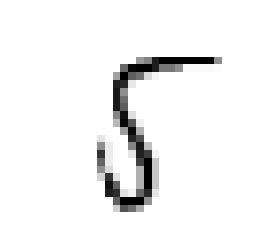

In [56]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# Extract the 36 thousandth image of the dataset, and return its dimensions.
some_digit = X[34000] 
some_digit_image = some_digit.reshape(28, 28)

# Plot the image, and output the target identity
print("The target identity is:" + str(y[34000]))
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

Before continuing with the data:
----
Split into training and testing sets, and randomly shuffle them.

In [5]:
import numpy as np

# Split the sets
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Shuffle
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

Now, first, we'll train a binary classifier to recognize the 1 that we extracted in the dataset.
----

In [6]:
from sklearn.linear_model import SGDClassifier

# Extract the 5's
y_train_5 = (y_train ==5)
y_test_5  = (y_test  ==5)

# Fit a Stochastic Gradient Descent model to the dataset to identify 5's
sgd_clf   = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

# See the classification of the 1:
print("Classifying the 5: " + str(sgd_clf.predict([some_digit])))

# Check how it classifies a 1
five = X[12345]
print("Classifying the 1: " + str(sgd_clf.predict([five])))

Classifying the 5: [ True]
Classifying the 1: [False]


Performance Measures
----
First, let's check out $\textbf{Stratified K-Fold}$

In [7]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

# Use the stratified k-fold to make 3 test/train splits.
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf     = clone(sgd_clf)            # The learning function
    X_train_folds = X_train[train_index]      # The training data for X
    y_train_folds = (y_train_5[train_index])  # The training data for y
    X_test_fold   = X_train[test_index]       # The testing data for X
    y_test_fold   = (y_train_5[test_index])   # The testing data for y
    
    clone_clf.fit(X_train_folds, y_train_folds)     # Fit to this fold's training data
    y_pred = clone_clf.predict(X_test_fold)         # Classify the testing data
    n_correct = sum(y_pred == y_test_fold)          # Sum up the classifications that were equal to actual
    print(float(n_correct) / float(len(y_pred)))    # After all of the work on this fold, output the percent correct

0.964
0.97025
0.9563


Now, let's check out the $\textbf{cross_val_score()}$ to evaluate our model using $\textbf{K-Fold Cross Validation}$.

In [8]:
from sklearn.model_selection import cross_val_score

# Get the cross validation score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([ 0.964  ,  0.97025,  0.9563 ])

Now, it's known that $\textbf{accuracy}$ isn't always the fairest assessment of a model.

Check out this toy example, naively scoring everything as not-5.

In [9]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
        
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([ 0.9138 ,  0.905  ,  0.91015])

It's important to note that the $\textbf{accuracy}$ for the model is still above 87% for a totally naive classifier.

A much better way to evaluate performance is the $\textbf{confusion matrix}$.

In [10]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

# Obtain a clean prediction for the data
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

# Create the confusion matrix
confusion_matrix(y_train_5, y_train_pred)

array([[54118,   461],
       [ 1728,  3693]])

From the $\textbf{confusion matrix}$, we can derive greater metrics for goodness of fit:

$\textbf{Precision:}$ $\frac{TP}{TP + FP}$ which is a measure of how often the data classified is correct to the target.

$\textbf{Recall:}$ $\frac{TP}{TP + FN}$ which is a measure of how much relevant information is retrieved by the algorithm.

In [11]:
from sklearn.metrics import precision_score, recall_score

print("Precision " + str(precision_score(y_train_5, y_train_pred)))
print("Recall " + str(recall_score(y_train_5, y_train_pred)))

Precision 0.889022628792
Recall 0.681239623686


This leads us to the $\textbf{F1 score}$ = $\frac{2}{\frac{1}{precision} + \frac{1}{recall}}$

Which is a balance between precision and recall.

In [12]:
from sklearn.metrics import f1_score

print("F1 score classifying 5's: " + str(f1_score(y_train_5, y_train_pred)))

F1 score classifying 5's: 0.77138381201


Beyond $\textbf{F1}$, we've got the idea of $\textbf{Precision/Recall tradeoff}$

Let's check out the $\textbf{Precision-Recall curve}$ for our dataset.

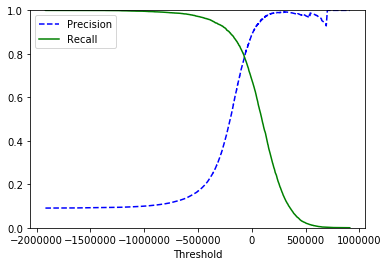

In [13]:
from sklearn.metrics import precision_recall_curve

# Use the SGD classifier to score the data in 3 fold cross validation using the decision function
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

# Plot the precision/recall curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

# A function to plot the scores
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0,1])
    
# Invocation of the function
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

# How to set the threshold
# y_scores = sgd_clg.decision_function([some_digit])
# y_scores
#
# threshold = 0
# y_digit_pred = (y_scores > threshold)
#
# Threshold is variate

The ROC Curve
----
The reciever operating characteristic (ROC) curve plots the true positive rate against the false positive rate.

Essentially, ROC is plotting sensitivity (recall) versus specificity.

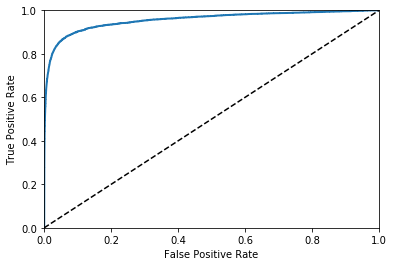

In [14]:
from sklearn.metrics import roc_curve

# Get the true positive, false positive, and thresholds.
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

# Plot FPR against TPR
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
# Invoke the function
plot_roc_curve(fpr, tpr)
plt.show()

Just like with precision and recall, there's a tradeoff.

The $\textbf{dotted-line}$ represents the ROC curve of a purely random classifier.

Following this, a way to compare classifiers is by looking at the $\textbf{area under the curve}$ or AUC

An AUC of 1 is a perfect classifier, whereas an AUC of .5 is totally random.

In [15]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.95619432473673605

Tip:
----
Since the $\textbf{ROC curve}$ is so similar to the $\textbf{precision/recall (or PR) curve}$, you may wonder how to decide which one to use. As a
rule of thumb, you should prefer the PR curve whenever the positive class is rare or when you care more about the false
positives than the false negatives, and the ROC curve otherwise.

Now that we've seen these metrics
----
Let's train a random forest classifier and compare its ROC curve and ROC AUC score to SGD.

Instead of decision_function() (as opposed to predict()), random forest has predict_proba(), or probability.

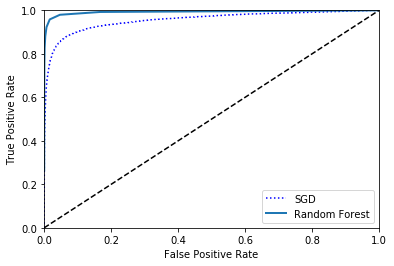

0.99276238540094852

In [16]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the classifier and cross validate
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

# Translate probability scores into the positive class's probability
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

# Plot
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

# Get ROC AUC score
roc_auc_score(y_train_5, y_scores_forest)

Moving forward into Multiclass Classification
----
Let's try and classify between more than just 5's and everything else.

Automatically, Scikit-Learn detects what type of classifier you're trying to run. In this instance, we're creating 10 binary classifiers; one for each digit.

In [18]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit]) # Is actually a 5.
sgd_clf.predict([five])       # Is actually a 1.

array([ 1.])

Effectively, this has just created $\textbf{10 binary classifiers}$, whereas before we were creating a singular classifier looking at 5's.

Let's look at each classifier's output for this variable:

In [19]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-165025.74463043, -432133.06921166, -432827.50368092,
        -161715.53138372, -302566.75472443,   82858.80459737,
        -747126.52058166, -375929.37032348, -634527.10779036,
        -552375.33671828]])

As you can see, $\textbf{5's array position has the highest score}$, rather, the classifier looking for 5 scored the highest.

In [20]:
# Classifier information
print("Highest scored class: " + str(np.argmax(some_digit_scores)))
print("All classes: " + str(sgd_clf.classes_))
print("Class 5: " + str(sgd_clf.classes_[5]))

Highest scored class: 5
All classes: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9.]
Class 5: 5.0


One Versus All, and One Versus One methods for binary classifiers
----

In [21]:
from sklearn.multiclass import OneVsOneClassifier

# Fit the classifier to the data using a OvO model
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)

# Classify the 5, output the total number of scores
print("Classification: " + str(ovo_clf.predict([some_digit])))
print("Number of models: " + str(len(ovo_clf.estimators_)))

Classification: [ 3.]
Number of models: 45


Instead of using the resources for OvA and OvO, using a $\textbf{Random Forest}$ is just as easy.

Luckily, Random Forest automatically handles multiclass problems. Rather than scores, if you remember, you can derive the probability of each class in classification.

In [22]:
forest_clf.fit(X_train, y_train)
print("Predicted class: " + str(forest_clf.predict([some_digit])))
print("Predicted probabilities: " + str(forest_clf.predict_proba([some_digit])))

Predicted class: [ 5.]
Predicted probabilities: [[ 0.   0.   0.   0.1  0.   0.9  0.   0.   0.   0. ]]


Let's get $\textbf{Random Forest's cross-validation}$ score.

In [23]:
# Random Forest Model
print("Random Forest Cross-val: " + str(cross_val_score(forest_clf, X_train, y_train, cv=3, scoring="accuracy")))

# OvO SGD model
print("SGD Cross-val: " + str(cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")))

Random Forest Cross-val: [ 0.93981204  0.94079704  0.94429164]
SGD Cross-val: [ 0.87677465  0.86894345  0.87343101]


To $\textbf{increase accuracy}$, we can simply $\textbf{scale}$ the inputs:

In [24]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

print("Scaled SGD score: " + str(cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")))
print("Scaled RF score: " + str(cross_val_score(forest_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")))

Scaled SGD score: [ 0.90756849  0.91189559  0.91143672]
Scaled RF score: [ 0.93971206  0.94094705  0.94434165]


As you can see, SGD had a pretty nice increase in accuracy, whereas Random Forest was largely unaffected.

Error Analysis
----
Just like in binary class problems, the $\textbf{confusion matrix}$ is an important tool in understanding OvO classifers.

In [25]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5732,    2,   27,   11,   12,   48,   40,    9,   39,    3],
       [   2, 6500,   41,   25,    6,   40,    7,   10,   98,   13],
       [  54,   37, 5356,  101,   84,   21,   87,   53,  148,   17],
       [  50,   44,  134, 5372,    3,  221,   30,   51,  137,   89],
       [  17,   29,   42,    8, 5376,    8,   49,   29,   89,  195],
       [  74,   47,   36,  183,   77, 4591,  109,   32,  177,   95],
       [  35,   26,   51,    2,   42,   85, 5626,    7,   43,    1],
       [  27,   24,   70,   29,   57,   10,    5, 5787,   17,  239],
       [  49,  168,   84,  164,   14,  155,   57,   22, 5014,  124],
       [  44,   38,   25,   85,  178,   29,    2,  199,   85, 5264]])

Instead of looking at the numerical representation, let's represent the confusion matrix as $\textbf{grayscale}$.

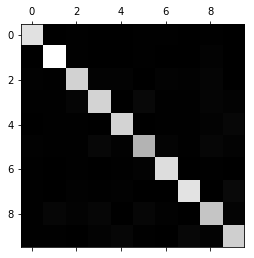

In [26]:
plt.matshow(conf_mx, cmap=plt.cm.gray)

# Notice that 5 is the darkest square, signifying the most difficult
# to classify correctly.

That's pretty cool, but let's focus on the $\textbf{error}$ in the classifier.

First, we'll divide each value in the confusion matrix by the total number of images in that class.

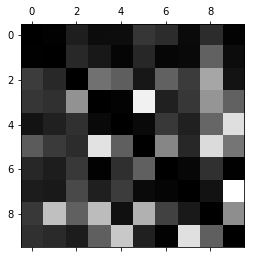

In [45]:
# Get the number of each class through row sums
row_sums = conf_mx.sum(axis=1, keepdims=True)

# Ensure row_sums is float
row_sums = np.ndarray.astype(row_sums, float)


# Derive the normalized confusion matrix
norm_conf_mx = np.divide(conf_mx, row_sums)

# Fill the diagonal with all 0's (instead of true positive/negative)
np.fill_diagonal(norm_conf_mx, 0)

# Plot
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

Let's break it down a bit:
----
-The upper white square is 5 being misclassified as 3.

-To its lower left, again, 3's are being misclassified as 5.

-In columns 7 and 9, 7's and 9's are being misclassified.

-In columns 8 and 9, 4 is misclassified as 9, and 8 is misclassified as 5.

Let's check some of these spots out:
----
We'll focus on the 3 and 5 misclassifications.

In the output images, the bottom left and bottom right clusters are correctly classified, conversely, the others are incorrect classifications.

In [53]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

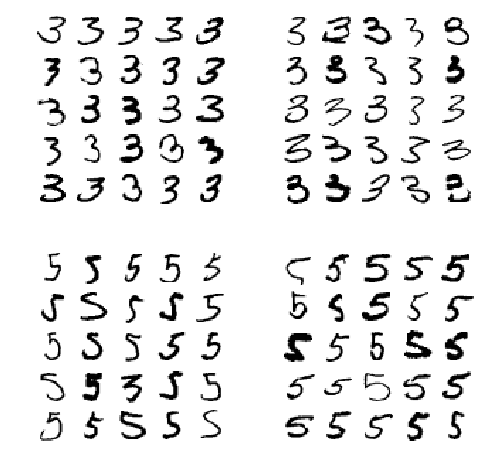

In [54]:
# Extract the 3 and 5 information
c1_a, c1_b = 3, 5
X_aa = X_train[(y_train == c1_a) & (y_train_pred == c1_a)]
X_ab = X_train[(y_train == c1_a) & (y_train_pred == c1_b)]
X_ba = X_train[(y_train == c1_b) & (y_train_pred == c1_a)]
X_bb = X_train[(y_train == c1_b) & (y_train_pred == c1_b)]

# Plot the information
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], 5)
plt.subplot(222); plot_digits(X_ab[:25], 5)
plt.subplot(223); plot_digits(X_ba[:25], 5)
plt.subplot(224); plot_digits(X_bb[:25], 5)
plt.show()

Multilabel Classification
----
Sometimes, your data needs multiple labels, for instance, in facial recognition. Essentially, there may be no obvious classification, so multiple opinions is better.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Prepare the augmented features
y_train_large = (y_train >= 7)
y_train_odd   = (y_train%2 == 1)
y_multilabel  = np.c_[y_train_large, y_train_odd]

# Fit the KNN model
knn_clf       = KNeighborsClassifer()
knn_clf.fit(X_train, y_multilabel)

